# バンディットアルゴリズム: テスト中の損失にも向き合う

ABテストでは、最適でないパターンを試す必要があるのでどうしても損失が発生してしまう。その影響をできるだけ少なくする方法を考える。

#### 探索と活用のジレンマ
2つの相反する行動のバランスをとることが重要 <br>
活用 : 自分の知りうるかぎり最適な行動をとって利益を得る <br>
探索 : 知識を増やすために新しい行動を試す <br>

#### 確率的バンディット問題

解を選んだ時の報酬がある確率分布にしたがっていると仮定し、累積報酬を最大にするような方策を求める。

||スロットマシン|web最適化|
|:-:|:-:|:-:|
|エージェント|ギャンブラー|webサイトを最適化するシステム|
|環境|スロットマシンの列|デザイン案の集合とユーザー|
|回数|予算(試すことのできる数)|デザイン案を表示する合計回数|
|報酬|得られた報酬|クリック|



#### バンディットアルゴリズムの性能の評価
n回目のシミュレーションで得られた累積報酬を$R_n(T)$とすると、累積報酬の期待値は、標本平均として推定できる。

$$\mathbb{E}[R(T)] \approx \frac{1}{N} \Sigma_{n=1}^{N} R_n(T)$$

解く問題によって、報酬のオーダーが異なるので、全知全能のエージェントとの累積報酬の差、リグレットを方策の評価に用いる。$x(t)$は時刻$t$に選択した解

$$
  Regret(T) = \Sigma_{t=1}^T (r_{x^*}(t) - r_{x(t)}(t))
$$

## 5.3 $\epsilon$-greedyアルゴリズム

$\epsilon$の確率で探索行動をとり、$1-\epsilon$の確率で、活用行動をとる。

時点$t$のある解x_kの標本平均$\hat{\theta}_k$は、

$$
 \hat{\theta}_k =  \frac{\Sigma_{\tau=1}^t  r(\tau) \mathbb{1} (x(\tau) = x_k)}{\Sigma_{\tau=1}^t \mathbb{1} (x(\tau) = x_k)}
$$

解$x_k$を選んだときの報酬の合計を、解$_k$を選んだ回数で割っただけ。
$\mathbb{1}(x)$は指示関数(xが真なら1、偽なら0)を表す。

活用行動をとるときは、$\hat{\theta}_k$が最大となる解を選択する。


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
n_arms = 4

class Env(object):
  # 成功率
  thetas = [0.1, 0.1, 0.2, 0.3]
  # 解のindexを与えられると報酬を返す
  def react(arm):
    return 1 if np.random.random() < Env.thetas[arm] else 0
  
  # 最適な解のindexを返す
  def opt():
    return np.argmax(Env.thetas)

In [ ]:
class EpsilonGreedyAgent(object):

  def __init__(self, epsilon=0.1):
    self.epsilon = epsilon
    self.counts = np.zeros(n_arms)
    self.values = np.zeros(n_arms)
  
  def get_arm(self):
    # 乱数を生成し、epsilonよりも小さければ、探索する
    if np.random.random() < self.epsilon:
      arm = np.random.randint(n_arms)
    # epsilonの確率で活用する(現在の最大報酬のarmのindexを返す)
    else:
      arm = np.argmax(self.values)
    return arm

  def sample(self, arm, reward):
    self.counts[arm] += 1
    # 報酬の更新式
    self.values[arm] = (
        (self.counts[arm] - 1) * self.values[arm] + reward
    ) / self.counts[arm]

In [ ]:
def sim(Agent, N=1000, T=1000, **kwargs):
  selected_arms = [[0 for _ in range(T)] for _ in range(N)]
  earned_rewards = [[0 for _ in range(T)] for _ in range(N)]

  for n in range(N):
    agent = Agent(**kwargs)
    for t in range(T):
      arm = agent.get_arm()
      reward = Env.react(arm)
      agent.sample(arm, reward)
      selected_arms[n][t] = arm
      earned_rewards[n][t] = reward
  return np.array(selected_arms), np.array(earned_rewards)

Text(0, 0.5, '$\\mathbb{E}[x(t) = x^*$')

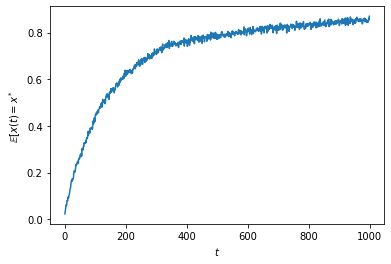

In [ ]:
arms_eg, rewards_eg = sim(EpsilonGreedyAgent)
acc = np.mean(arms_eg == Env.opt(), axis=0)

plt.plot(acc)
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*$')

In [ ]:
# 全知全能のエージェント
class OracleAgent(object):
  def __init__(self):
    self.arm = Env.opt()
  
  def get_arm(self):
    return self.arm
  
  def sample(self, arm, reward):
    pass

In [ ]:
print(rewards_eg)

[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


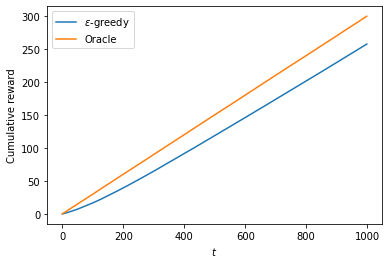

In [ ]:
arms_o, rewards_o = sim(OracleAgent)
plt.plot(np.mean(np.cumsum(rewards_eg, axis=1),axis=0),label=r'$\epsilon$-greedy')
plt.plot(np.mean(np.cumsum(rewards_o, axis=1),axis=0),label=r'Oracle')
plt.xlabel(r'$t$')
plt.ylabel('Cumulative reward')
plt.legend()
plt.show()

## 焼きなまし $\epsilon$-greedyアルゴリズム

In [ ]:
class AnnealingEpsilonGreedyAgent(object):

  def __init__(self, epsilon=1.0):
    self.epsilon = epsilon
    self.counts = np.zeros(n_arms)
    self.values = np.zeros(n_arms)

  def get_arm(self):
    if np.random.random() < self.epsilon:
      arm = np.random.randint(n_arms)
    else:
      arm = np.argmax(self.values)
    # epsilonがget_armのたびに小さくなる
    self.epsilon *= 0.99
    return arm
  
  def sample(self, arm, reward):
    self.counts[arm] += 1
    self.values[arm] = (
        (self.counts[arm] -1)*self.values[arm] + reward
    ) / self.counts[arm]
        

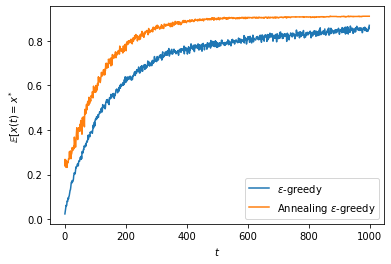

In [ ]:
arms_aeg, rewards_aeg = sim(AnnealingEpsilonGreedyAgent)
acc_aeg = np.mean(arms_aeg == Env.opt(), axis=0)

plt.plot(acc, label='$\epsilon$-greedy')
plt.plot(acc_aeg, label='Annealing $\epsilon$-greedy')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*$')
plt.legend()
plt.show()

## 5.5 ソフトマックスアルゴリズム

$\epsilon$-greedyのように、一定確率で、ランダムな解を探索するのではなく、ソフトマックス関数により、探索確率を決定する。
解の報酬の標本平均$\hat{\theta}_k(t)$に応じて、表示する確率を変化させる。

$$
p (t, x_k) = \frac{exp(\frac{\hat{\theta}_k(t)}{\tau})}{\Sigma_{k=1}^K exp(\frac{\hat{\theta}_k(t)}{\tau})}
$$

$\tau$は、スケール補正のためのパラメータ

In [ ]:
class SoftmaxAgent(object):

  def __init__(self,tau=0.05):
    self.tau = tau
    self.counts = np.zeros(n_arms)
    self.values = np.zeros(n_arms)

  def softmax_p(self):
    logit = self.values / self.tau
    logit = logit - np.max(logit)
    p = np.exp(logit) / sum(np.exp(logit))
    return p

  def get_arm(self):
    arm = np.random.choice(n_arms, p=self.softmax_p())
    return arm

  def sample(self, arm, reward):
    self.counts[arm] += 1
    self.values[arm] = (
        (self.counts[arm] -1)*self.values[arm] + reward
    ) / self.counts[arm]
        

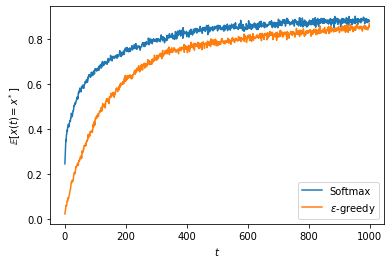

In [ ]:
agent_sm = SoftmaxAgent
arms_sm, rewards_sm = sim(agent_sm)


plt.plot(np.mean(arms_sm == Env.opt(), axis=0), label=r'Softmax')
plt.plot(np.mean(arms_eg == Env.opt(), axis=0),
          label=r'$\varepsilon$-greedy')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

In [ ]:
class AnnealingSoftmaxAgent(object):

  def __init__(self, tau=1000.):
    self.tau = tau
    self.counts = np.zeros(n_arms)
    self.values = np.zeros(n_arms)

  def softmax_p(self):
    logit = self.values / self.tau
    logit = logit - np.max(logit)
    p = np.exp(logit) / sum(np.exp(logit))
    return p

  def get_arm(self):
    arm = np.random.choice(n_arms, p=self.softmax_p())
    self.tau = self.tau * 0.9
    return arm

  def sample(self, arm, reward):
    self.counts[arm] = self.counts[arm] + 1
    self.values[arm] = (
        (self.counts[arm] - 1) * self.values[arm] + reward
        ) / self.counts[arm]

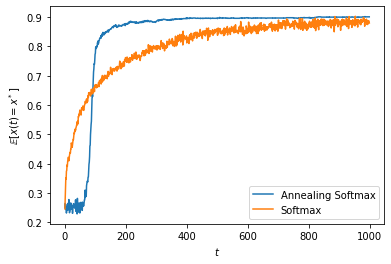

In [ ]:
arms_asm, rewards_asm = sim(AnnealingSoftmaxAgent)

plt.plot(np.mean(arms_asm == Env.opt(), axis=0),
          label='Annealing Softmax')
plt.plot(np.mean(arms_sm == Env.opt(), axis=0), label='Softmax')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

## 5.6 トンプソン抽出

ベイズ推論による報酬の期待値の事後分布から、選択肢を決定する

In [ ]:
class BernoulliTSAgent(object):

  def __init__(self):
    self.counts = [0 for _ in range(n_arms)]
    self.wins = [0 for _ in range(n_arms)]

  def get_arm(self):
    # ベータ分布
    beta = lambda N, a: np.random.beta(a+1, N-a+1)
    # 試行回数と報酬を入れる
    result = [beta(self.counts[i], self.wins[i]) for i in range(n_arms)]
    arm = result.index(max(result))
    return arm

  def sample(self, arm, reward):
    self.counts[arm] = self.counts[arm] + 1
    self.wins[arm] = self.wins[arm] + reward

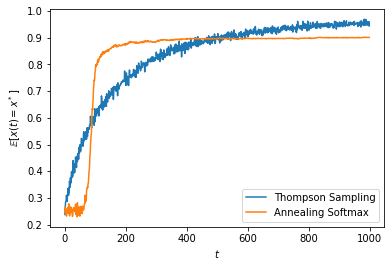

In [ ]:
arms_ts, rewards_ts = sim(BernoulliTSAgent)

plt.plot(np.mean(arms_ts == Env.opt(), axis=0),
          label='Thompson Sampling')
plt.plot(np.mean(arms_asm == Env.opt(), axis=0),
          label='Annealing Softmax')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

## 5.7 UCBアルゴリズム

信頼区間の上限が最大となる解を選択するアルゴリズム。<br>
UCB値 = 信頼区間(confidence inteval)の上側(upper bound)

$$
 UCB_k(t) = \hat{\theta_k}(t) + \sqrt{\frac{log(t)}{2N_k(t)}}
$$
第1項が、報酬の標本平均なので、活用の役割。第2項は、試行回数が少ないほど大きくなるので探索の役割。


In [ ]:
class UCBAgent(object):

  def __init__(self):
    self.counts = [0 for _ in range(n_arms)]
    self.values = [0 for _ in range(n_arms)]

  def calc_ucb(self, arm):
    ucb = self.values[arm]
    ucb += np.sqrt(np.log(sum(self.counts)) / (2*  self.counts[arm]))
    return ucb

  def get_arm(self):
    if 0 in self.counts:
      arm = self.counts.index(0)
    else:
      ucb = [self.calc_ucb(arm) for arm in range(n_arms)]
      arm = ucb.index(max(ucb))
    return arm
  
  def sample(self, arm, reward):
    self.counts[arm] = self.counts[arm] + 1
    self.values[arm] = (
        (self.counts[arm] - 1) * self.values[arm] + reward
        ) / self.counts[arm]

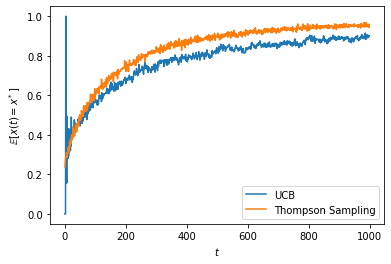

In [ ]:
arms_ucb, rewards_ucb = sim(UCBAgent)

plt.plot(np.mean(arms_ucb == Env.opt(), axis=0), label='UCB')
plt.plot(np.mean(arms_ts == Env.opt(), axis=0),
          label='Thompson Sampling')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()